<h1 style="text-align:center;font-size:30px;color:red"> Quora Question Pairs </h1>

<img src="quora_img.png">

<h3 style="font-size:20px;color:blue"> Description </h3>

<p1> Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.</p>

<h3 style="font-size:20px;color:blue"> Problem Statement </h3>

- Identify which questions asked on Quora are duplicates of questions that have already been asked.
- This could be useful to instantly provide answers to questions that have already been answered.
- We are tasked with predicting whether a pair of questions are duplicates or not.

<h3 style="font-size:20px;color:blue">Real world/Business Objectives and Constraints </h3>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h3 style="font-size:20px;color:blue"> Machine Learning Probelm </h3>

<h4>Data Overview</h4> 

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3 style="font-size:20px;color:blue"> Mapping the real world problem to an ML problem</h3>


<h4>Type of Machine Leaning Problem</h4>

- It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

<h4>Performance Metric </h4>

- log-loss
- Binary Confusion Matrix

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)a
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

import sqlite3
from sqlalchemy import create_engine # database connection
import csv
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [4]:
import scipy

In [3]:
df = pd.read_csv("train.csv")

print("Number of data points:", df.shape[0])

Number of data points: 404290


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


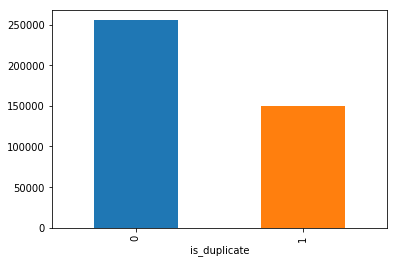

In [6]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [7]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [8]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [9]:
#number of unique questions
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Total number of Unique Questions are: {}\n'.format(unique_qs))

print('Number of unique questions that appear more than one time : {} ({}%)\n'.format(qs_morethan_onetime , qs_morethan_onetime/unique_qs*100))

print('Max number of times a single question is repeated : {}\n'.format(max(qids.value_counts())))

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of Unique Questions are: 537933

Number of unique questions that appear more than one time : 111780 (20.77953945937505%)

Max number of times a single question is repeated : 157



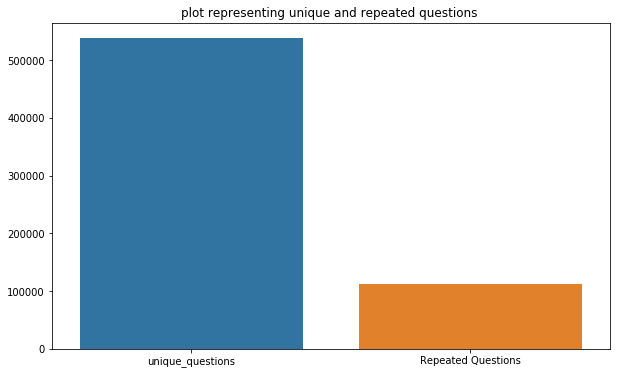

In [10]:
x = ["unique_questions" , "Repeated Questions"]
y = [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10,6))
plt.title("plot representing unique and repeated questions ")
sns.barplot(x,y)
plt.show()

In [11]:
# checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1' , 'qid2']).count().reset_index()

print("Number of duplicate questions", (pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


Maximum number of times a single question is repeated: 157



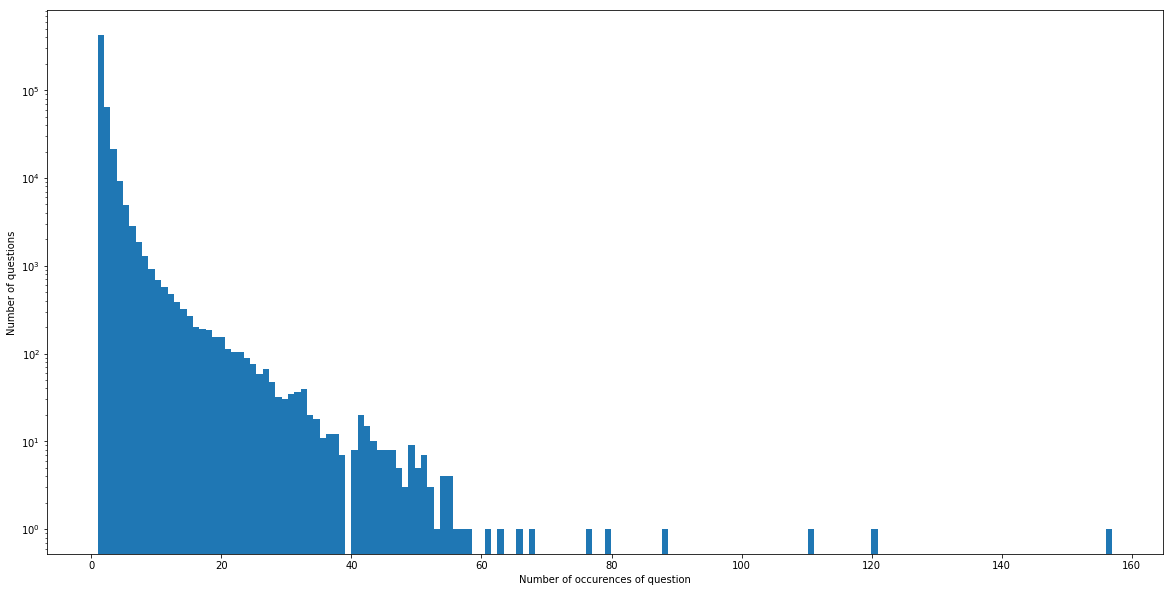

In [12]:
# Number of occurrences of each question
plt.figure(figsize=(20,10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

In [13]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2

In [14]:
#Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


### Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [15]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv", encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    
    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0* len(w1 & w2)
    
    df['word_Common'] = df.apply(normalized_word_Common , axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip() , row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)
    
    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
    
    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()
    

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


###  Analysis of some of the extracted features

- Here are some questions have only one single words.

In [16]:
print("Minimum length of the questions in question1 : ", min(df['q1_n_words']))
print("Minimum length of the questions in question2 : ", min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


#### Feature: word_shapre

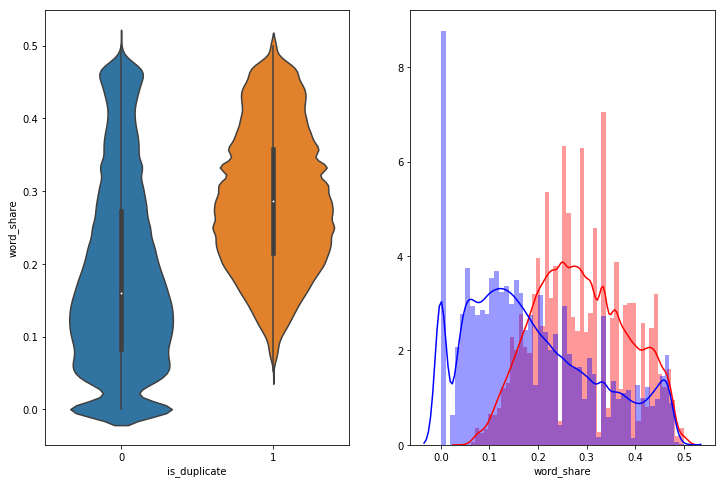

In [17]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:], label = "1", color= 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:], label = "0", color='blue')

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

#### Feature: word_Common

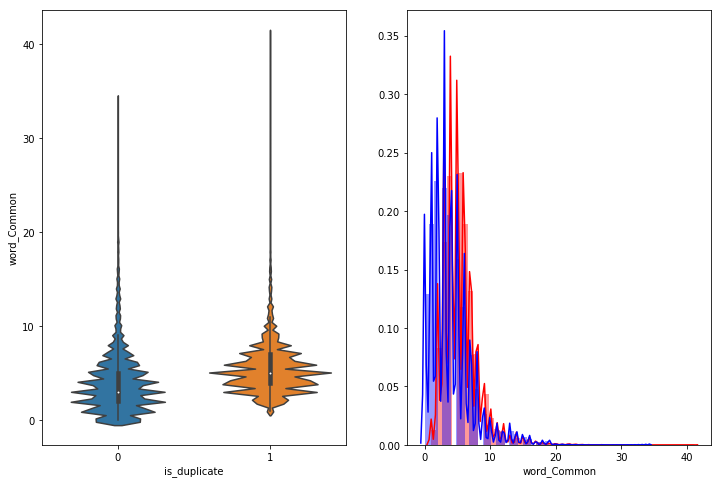

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

## EDA : Advanced Feature Extraction

In [19]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


### Preprocessing of Text

- Preprocessing:
    - Removing html tags
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc

In [20]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

### Advanced Feature Extraction (NLP and Fuzzy Features) 

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [31]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [32]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>Analysis of extracted features </h3>

<h4>Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [33]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and filatten the array : like {{1,2}, {3,4} }  to {1,2,3,4} 

p = np.dstack([df_duplicate["question1"] , df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [34]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


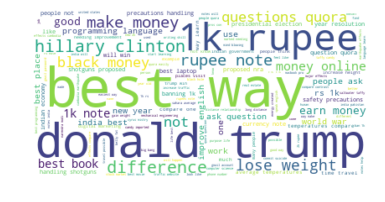

In [35]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


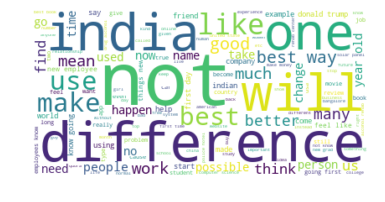

In [36]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

####  Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

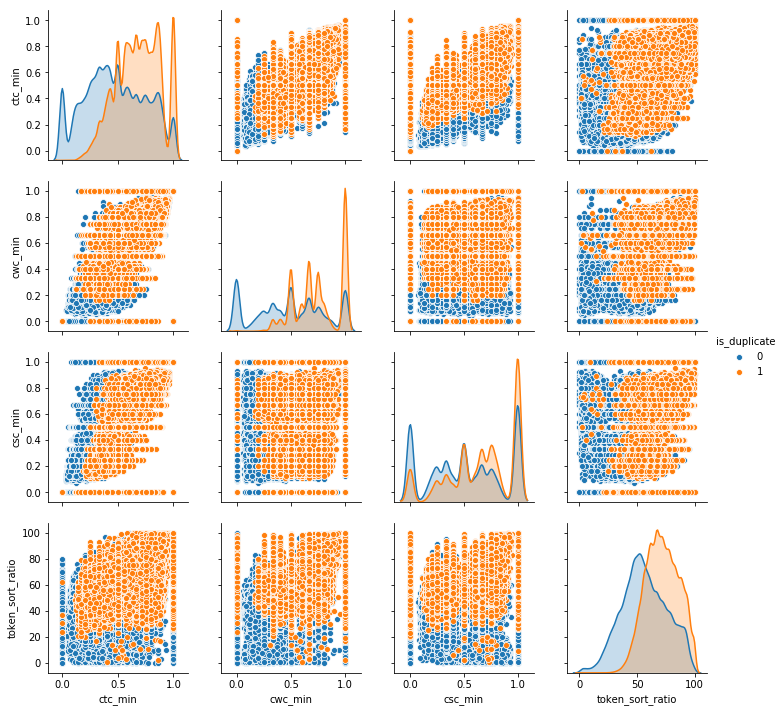

In [37]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

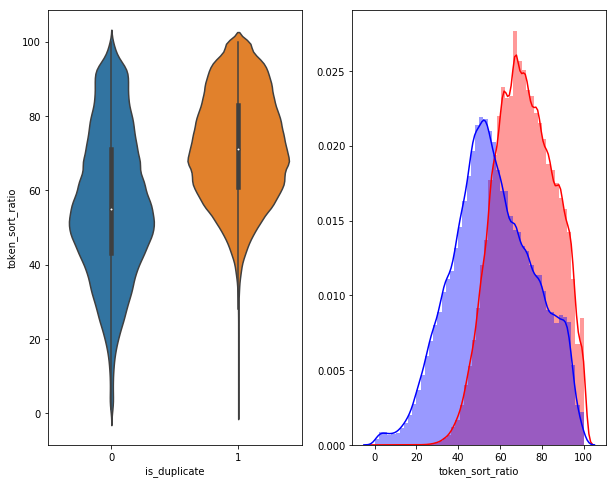

In [38]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

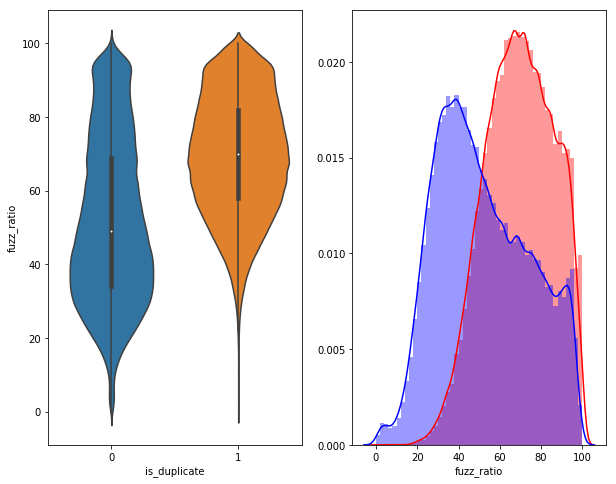

In [39]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

##  Visualization

In [40]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [41]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.092s...
[t-SNE] Computed neighbors for 5000 samples in 0.671s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.614s
[t-SNE] Iteration 50: error = 81.2911148, gradient norm = 0.0457501 (50 iterations in 4.529s)
[t-SNE] Iteration 100: error = 70.6044159, gradient norm = 0.0086692 (50 iterations in 3.014s)
[t-SNE] Iteration 150: error = 68.9124908, gradient norm = 0.0056016 (50 iterations in 2.859s)
[t-SNE] Iteration 200: error = 68.1010742, gradient norm = 0.0047585 (50 iterations in 2.972s)
[t-SNE] Iteration 250: error = 67.5907974, gradient norm = 0.0033576

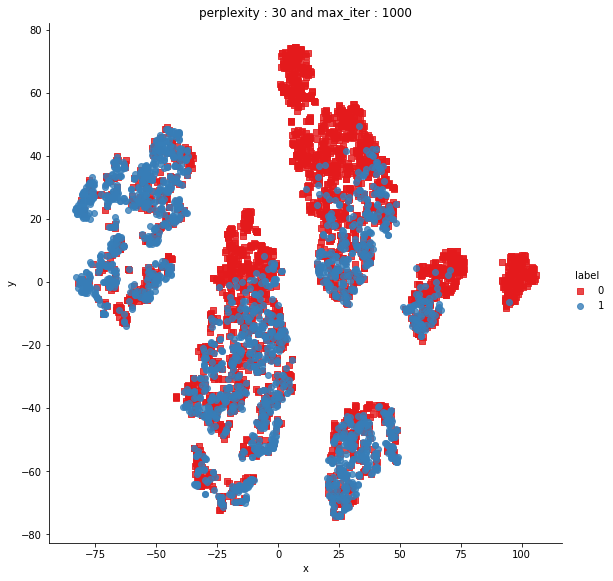

In [42]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [43]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.679s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.504s
[t-SNE] Iteration 50: error = 80.5316772, gradient norm = 0.0296611 (50 iterations in 22.021s)
[t-SNE] Iteration 100: error = 69.3823166, gradient norm = 0.0032796 (50 iterations in 10.199s)
[t-SNE] Iteration 150: error = 67.9726028, gradient norm = 0.0016793 (50 iterations in 9.181s)
[t-SNE] Iteration 200: error = 67.4176178, gradient norm = 0.0010922 (50 iterations in 9.438s)
[t-SNE] Iteration 250: error = 67.1033630, gradient norm = 0.00088

In [44]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [46]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [47]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [58]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [76]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2', 'id', 'is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate','id'],axis=1)
df3 = df.drop(['qid1','qid2','id'],axis=1)

In [77]:
df1.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [78]:
df2.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [79]:
df3.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [80]:
df3["question1"] = df3["question1"].fillna("").apply(preprocess)
df3["question2"] = df3["question2"].fillna("").apply(preprocess)

In [81]:
df3.head()

,question1,question2,is_duplicate
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0
4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


In [82]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

(404290, 15)
(404290, 11)
(404290, 3)


In [84]:
df1['id'] = [i for i in range(404290)]
df2['id'] = [i for i in range(404290)]
df3['id'] = [i for i in range(404290)]

In [86]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3  = df3.merge(df2,on='id',how='left')
    df3  = df3.merge(df1,on='id',how='left')
    df3.to_csv('final_features.csv')

In [88]:
Y = df3['is_duplicate']
X = df3.drop('is_duplicate', axis=1)

In [90]:
from sklearn.model_selection import train_test_split

In [91]:
X_train,X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(min_df=5)
tfidf.fit(questions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [155]:
len(tfidf.get_feature_names())

25282

In [5]:
from scipy.sparse import coo_matrix
import scipy

In [160]:
X_train_q1 = coo_matrix(tfidf.transform(X_train['question1']))
X_train_q2 = coo_matrix(tfidf.transform(X_train['question2']))

In [161]:
X_train_q1.shape

(283003, 25282)

In [162]:
X_train_q2.shape

(283003, 25282)

In [163]:
X_train_q1_q2 = scipy.sparse.hstack((X_train_q1, X_train_q2))
scipy.sparse.save_npz("X_train_q1_q2.npz", X_train_q1_q2)

In [164]:
X_train_q1_q2

<283003x50564 sparse matrix of type '<class 'numpy.float64'>'
	with 5647482 stored elements in COOrdinate format>

In [165]:
X_test_q1 = coo_matrix(tfidf.transform(X_test['question1']))
X_test_q2 = coo_matrix(tfidf.transform(X_test['question2']))

X_test_q1_q2 = scipy.sparse.hstack((X_test_q1, X_test_q2))
scipy.sparse.save_npz("X_test_q1_q2.npz", X_test_q1_q2)

In [166]:
X_test_q1.shape

(121287, 25282)

In [167]:
X_test_q2.shape

(121287, 25282)

In [168]:
X_test_q1_q2.shape

(121287, 50564)

In [118]:
X_train_no_tfidf = X_train.drop(['question1', 'question2','id'], axis=1)
X_test_no_tfidf = X_test.drop(['question1', 'question2','id'], axis=1)

X_train_no_tfidf = np.array(X_train_no_tfidf)
X_test_no_tfidf = np.array(X_test_no_tfidf)

In [169]:
X_train_final = scipy.sparse.hstack((X_train_no_tfidf, X_train_q1_q2))
X_test_final = scipy.sparse.hstack((X_test_no_tfidf, X_test_q1_q2))

In [170]:
X_test_final.shape

(121287, 50590)

In [172]:
X_train_final.shape

(283003, 50590)

In [173]:
scipy.sparse.save_npz("X_train_final.npz", X_train_final)
scipy.sparse.save_npz("X_test_final.npz", X_test_final)

In [5]:
X_train_final = scipy.sparse.load_npz("X_train_final.npz")
X_test_final = scipy.sparse.load_npz("X_test_final.npz")

In [174]:
np.save("y_train.npy", y_train)
np.save("y_test.npy",y_test)

In [6]:
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [7]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6301947329180256 Class 1:  0.3698052670819744
---------- Distribution of output variable in test data ----------
Class 0:  0.36778055356303646 Class 1:  0.36778055356303646


In [8]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.887986141587283


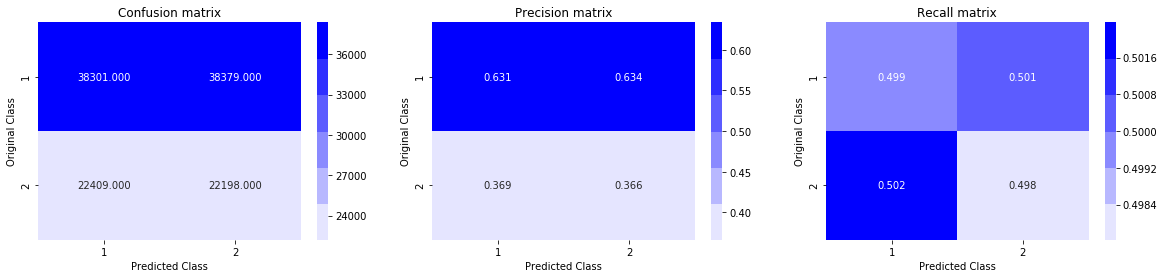

In [9]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Assignments

#### Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
C = [10 ** x for x in range(-5, 2)] #Hyperparameters 

log_error_array = []

for i in C:
    clf = LogisticRegression(C=i, penalty='l1')
    clf.fit(X_train_final , y_train)
    predict_y = clf.predict_proba(X_test_final)
    log_error_array.append(log_loss(y_test, predict_y))
    print('For values of alpha = ', i, "The log loss is : ",log_loss(y_test, predict_y))

For values of alpha =  1e-05 The log loss is :  0.5639018216726743
For values of alpha =  0.0001 The log loss is :  0.4758010198922024
For values of alpha =  0.001 The log loss is :  0.43085331599330706
For values of alpha =  0.01 The log loss is :  0.4086512961198796
For values of alpha =  0.1 The log loss is :  0.38013118168319154
For values of alpha =  1 The log loss is :  0.36028017700335574
For values of alpha =  10 The log loss is :  0.4050001803564682


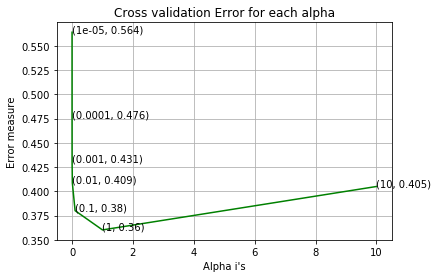

In [12]:
fig, ax = plt.subplots()
ax.plot(C, log_error_array , c = 'g')
for i , txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((C[i], np.round(txt,3)), (C[i], log_error_array[i]))
plt.grid()
plt.title("Cross validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best C =  1 The train log loss is: 0.331123802842563
For values of best C =  1 The test log loss is: 0.3602795275278825
Total number of data points : 121287


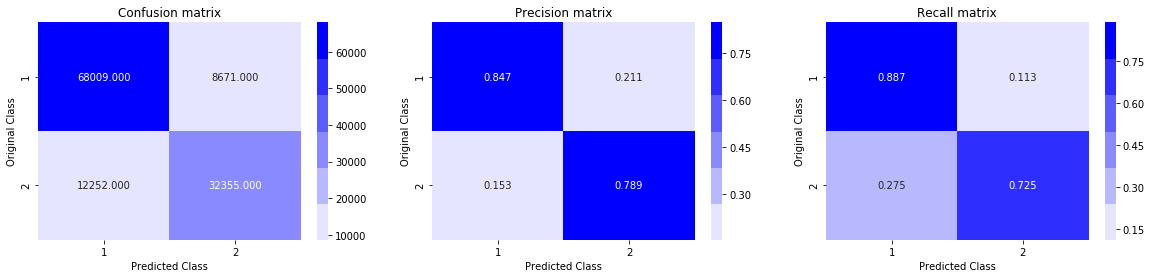

In [13]:
best_C = np.argmin(log_error_array)
clf = LogisticRegression(C=C[best_C], penalty='l1')
clf.fit(X_train_final, y_train)

predict_y = clf.predict_proba(X_train_final)
print('For values of best C = ', C[best_C], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf.predict_proba(X_test_final)
print('For values of best C = ', C[best_C], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Linear-SVM

In [185]:
alpha = [10 ** x for x in range(-5, 2)]

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train)
    predict_y = sig_clf.predict_proba(X_test_final)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.46027481491319144
For values of alpha =  0.0001 The log loss is: 0.48135681645364076
For values of alpha =  0.001 The log loss is: 0.5078195121421616
For values of alpha =  0.01 The log loss is: 0.5161922829916686
For values of alpha =  0.1 The log loss is: 0.4898780030371454
For values of alpha =  1 The log loss is: 0.5878611630991508
For values of alpha =  10 The log loss is: 0.6342679561431821


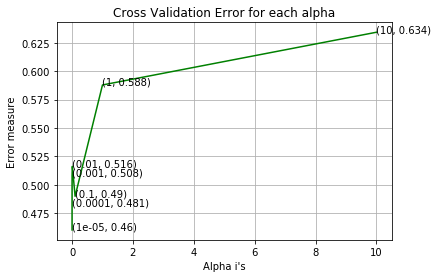

In [186]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  1e-05 The train log loss is: 0.4609891589352754
For values of best alpha =  1e-05 The test log loss is: 0.46027481491319144
Total number of data points : 121287


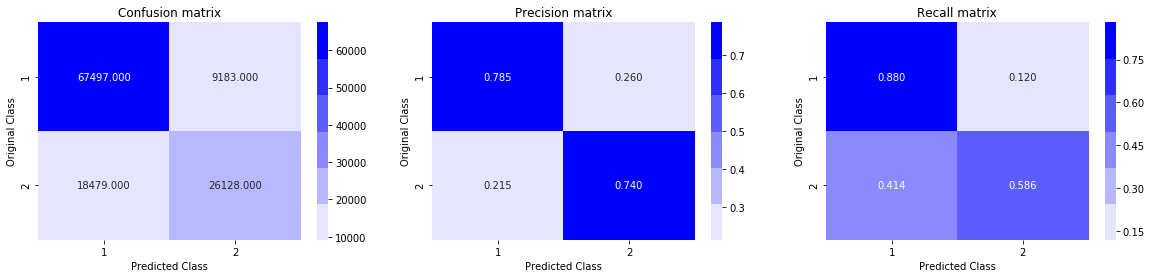

In [188]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_final, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train)

predict_y = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### XgBoost 

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from random import uniform , randint
import time
from time import time
from scipy.stats import randint as sp_randint

In [18]:
n_estimators = [20,40,60,80]
max_depth = [1,5,10,50,100]
train_logloss = []
test_logloss = []
for i in n_estimators:
    for j in max_depth:
        XGBC = XGBClassifier(n_estimators=i, max_depth=j, learning_rate=0.1 , subsample=0.5 , colsample_bytree=0.6)
        XGBC.fit(X_train_final, y_train)
        predict_y = XGBC.predict_proba(X_train_final)
        train_logloss.append(log_loss(y_train, predict_y))
        predict_y = XGBC.predict_proba(X_test_final)
        test_logloss.append(log_loss(y_test, predict_y))
        print('For n_estimators = ', i, "For max_depth = ", j , "The log loss is : ",log_loss(y_test, predict_y))

For n_estimators =  20 For max_depth =  1 The log loss is :  0.505317008570422
For n_estimators =  20 For max_depth =  5 The log loss is :  0.40512208062513017
For n_estimators =  20 For max_depth =  10 The log loss is :  0.37166848886404164
For n_estimators =  20 For max_depth =  50 The log loss is :  0.35380716501560255
For n_estimators =  20 For max_depth =  100 The log loss is :  0.35320647914112396
For n_estimators =  40 For max_depth =  1 The log loss is :  0.4594901655361766
For n_estimators =  40 For max_depth =  5 The log loss is :  0.36655743800223484
For n_estimators =  40 For max_depth =  10 The log loss is :  0.33510101852921775
For n_estimators =  40 For max_depth =  50 The log loss is :  0.3172568716427387
For n_estimators =  40 For max_depth =  100 The log loss is :  0.3160795764098314
For n_estimators =  60 For max_depth =  1 The log loss is :  0.43886784540460644
For n_estimators =  60 For max_depth =  5 The log loss is :  0.3548624613874577
For n_estimators =  60 For

===================Test Data===================


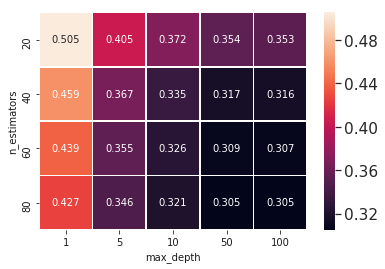

In [19]:
fig, ax = plt.subplots()
# auc on test
print("===================Test Data===================")
test_scores = np.array(test_logloss).reshape(len(n_estimators),len(max_depth))
df_cm_cv = pd.DataFrame(test_scores, n_estimators, max_depth)
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm_cv, annot=True, annot_kws={"size": 10}, fmt='.3g',linewidths=.5)
ax.set_xlabel("max_depth")
ax.set_ylabel("n_estimators")
plt.show()

For n_estimators =  80 For max_depth =  100 The log loss is :  0.3050986576600217


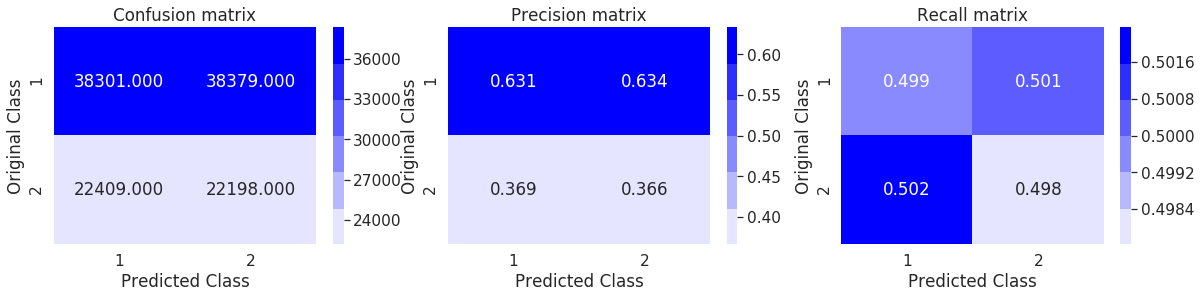

In [20]:
i = 80 # n_estimators
j = 100 # max_depth
XGBC = XGBClassifier(n_estimators=i, max_depth=j, learning_rate=0.1 , subsample=0.5 , colsample_bytree=0.6)
XGBC.fit(X_train_final, y_train)
predict_y = XGBC.predict_proba(X_test_final)
print('For n_estimators = ', i, "For max_depth = ", j , "The log loss is : ",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, predicted_y)

For n_estimators =  80 For max_depth =  100 The log loss is :  0.3050986576600217
Total number of data points : 121287


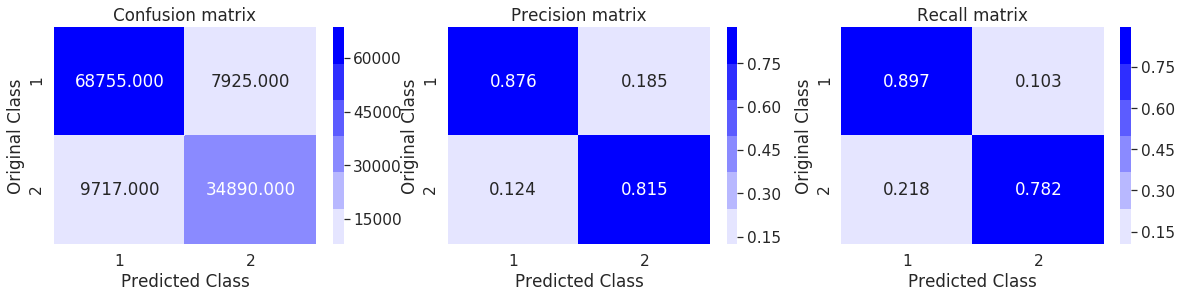

In [45]:
print('For n_estimators = ', i, "For max_depth = ", j , "The log loss is : ",log_loss(y_test, predict_y))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Conclusions

In [47]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
x = PrettyTable(["Algorithm" , "log loss"])

x.add_row(["Logistic regression", "0.3602795275278825"])
x.add_row(["Linear-SVM", "0.46027481491319144"])
x.add_row(["XgBoost", "0.3050986576600217"])
print(x.get_string(title=""))

+---------------------+---------------------+
|      Algorithm      |       log loss      |
+---------------------+---------------------+
| Logistic regression |  0.3602795275278825 |
|      Linear-SVM     | 0.46027481491319144 |
|       XgBoost       |  0.3050986576600217 |
+---------------------+---------------------+


<h2 stype="font-size:20px;color:red"> Step by step procedure followed to solve this case studey </h2>

- first we load the train.csv data set into data frame
- we find number of data points : 404290
- we find there are 6 columns in data
- those are [id , qid1, qid2, question1, question2. is_duplicate ]
- clearly observe that is_dupicate is labeled column
- Question pairs are not Similar (is_duplicate = 0):
   63.08%
- Question pairs are Similar (is_duplicate = 1):
   36.92%
- we done some EDA to understand data much more rigorous
- we find Total number of Unique Questions are: 537933
- Number of unique questions that appear more than one time : 111780 (20.77953945937505%)
- Max number of times a single question is repeated : 157
- Number of duplicate questions 0
- Maximum number of times a single question is repeated: 157
- Checking whether there are any rows with null values
- There are two rows with null values in question2

<h4 stype="font-size:20px;color:blue"> Basic Feature Extraction (before cleaning) </h4>

- hear we done some basic feature extraction
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 
 
<h4 stype="font-size:20px;color:blue"> Analysis of some of the extracted features </h4>

- we find some questions have only one single words.
- Minimum length of the questions in question1 :  1
- Minimum length of the questions in question2 :  1
- Number of Questions with minimum length [question1] : 67
- Number of Questions with minimum length [question2] : 24

- when we perform univariat analysis on Feature : word_shapre
- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)
- Feature: word_Common
- The distributions of the word_Common feature in similar and non-similar questions are highly overlapping


<h4 stype="font-size:20px;color:blue"> EDA : Advanced Feature Extraction </h4>

- we done some advanced feature extraction on data

<h5 stype="font-size:10px;color:blue"> Preprocessing of Text</h5>

- Removing html tags
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc

<h5 stype="font-size:10px;color:blue"> Preprocessing of Text</h5>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

- append the new features as a columns to data set

Plotting Word clouds:
- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

Visualization :

- we visualize the data using TSNE
- we find some labels are well separated and some labels are overlaped



<h4 stype="font-size:20px;color:green"> Vectorizer & train and test data </h4>

- we drop some columns [qid1, qid2]
- we merge three data frames by using id column
- take X = total data
- take Y = labels
- split the data into train and test data

- applying tfidf vectorizer on train data
- trainsform the vectorizer to X_train_q1 and X_train_q2
- we find most of columns/values are zeros
- so we convert train and test vectorized data into sparse matrix
- then merge X_train_q1 and X_train_q2 using hstack function
- done both train and test data
- save those train and test data as .npz files

<h4 stype="font-size:20px;color:green"> Machine Learning Models </h4>

- our loss function is logloss
- in order to find best logloss first we build a random model to find log-loss
- we observe log_loss on test data using random mode : 0.887
- in order to reduce log loss we apply some machine learnign algorithams

<h5 stype="font-size:20px;color:green">Logistic Regression </h5>

- when we apply logistic regression we done hyperparameter tuning 
- we find best hyperparameter C / (1/lambda) is : 1
- log-loss its reduced is : 0.3602
- we are using l1 reglarization because the features are very high
- then we plot confusion matrix and Rresision and recall matrixs

<h5 stype="font-size:20px;color:green">Linear SVM</h5>

- when we apply linear SVM we done hyperparameter tuning 
- we find best hyperparameter alpha is : 0.00001
- log-loss its reduced is : 0.4602
- we are using l1 reglarization because the features are very high
- then we plot confusion matrix and Rresision and recall matrixs

<h5 stype="font-size:20px;color:green">XgBoost</h5>

- when we apply XgBoost we done hyperparameter tuning 
- we find best hyperparameter n_estimators : 80 and max_depth : 100
- log-loss its reduced is : 0.3050
- then we plot confusion matrix and Rresision and recall matrixs